In [1]:

!nvidia-smi

Wed Apr  2 14:19:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.24                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P5              6W /   20W |    2001MiB /   8188MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from scipy.io import arff


In [3]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F


In [4]:
sns.set(style= 'whitegrid', palette= 'muted', font_scale= 1.2)
...
np.random.seed(42)
torch.manual_seed(42)


In [5]:
import zipfile

with zipfile.ZipFile("ECG5000.zip", "r") as zip_ref:
    zip_ref.extractall()



In [8]:
import pandas as pd
from scipy.io import arff

data_train, _ = arff.loadarff("ECG5000_TRAIN.arff")
data_test, _ = arff.loadarff("ECG5000_TEST.arff")

train = pd.DataFrame(data_train)
test = pd.DataFrame(data_test)

train['target'] = train['target'].str.decode('utf-8')
test['target'] = test['target'].str.decode('utf-8')

# ✅ Use concat instead of append
df = pd.concat([train, test], ignore_index=True)
df = df.sample(frac=1.0)


In [10]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [15]:
test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,1


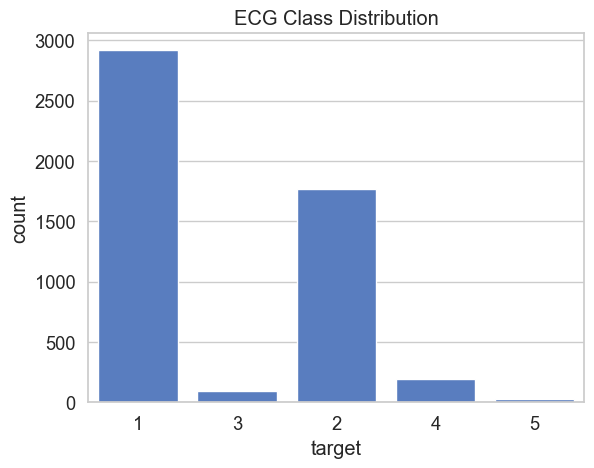

In [20]:
# Define which class is 'normal'
CLASS_NORMAL = '1'

# Rename last column as 'target' if not already
df.columns = list(df.columns[:-1]) + ['target']

# Optional: visualize class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title("ECG Class Distribution")
plt.show()


In [21]:
# Normal class
normal_df = df[df['target'] == CLASS_NORMAL].drop('target', axis=1)

# Anomaly class (everything not normal)
anomaly_df = df[df['target'] != CLASS_NORMAL].drop('target', axis=1)


In [22]:
from sklearn.model_selection import train_test_split

# Split normal data: 85% train, 15% val+test
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=42)

# Split val+test evenly
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)


In [23]:
import torch
import numpy as np

# Convert to list of float32 arrays
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

# Helper function
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

# Apply to all sets
train_dataset, seq_len, n_features = create_dataset(train_sequences)
val_dataset, _, _ = create_dataset(val_sequences)
test_dataset, _, _ = create_dataset(test_sequences)
test_anomaly_dataset, _, _ = create_dataset(anomaly_sequences)


In [24]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))  # [batch, seq_len, features]
        x, _ = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))


In [25]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)


In [26]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=128)
model = model.to(device)


In [28]:
import torch.optim as optim

loss_fn = nn.MSELoss()  # Mean Squared Error – for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [29]:
n_epochs = 150
train_loss_list = []
val_loss_list = []

for epoch in range(n_epochs):
    model.train()
    loss_train = 0

    for seq in train_dataset:
        seq = seq.to(device)
        optimizer.zero_grad()

        output = model(seq)
        loss = loss_fn(output, seq)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

    model.eval()
    with torch.no_grad():
        loss_val = 0
        for seq in val_dataset:
            seq = seq.to(device)
            output = model(seq)
            loss = loss_fn(output, seq)
            loss_val += loss.item()

    train_loss_list.append(loss_train / len(train_dataset))
    val_loss_list.append(loss_val / len(val_dataset))

    print(f"[{epoch+1}/{n_epochs}] Train Loss: {train_loss_list[-1]:.6f} | Val Loss: {val_loss_list[-1]:.6f}")


[1/150] Train Loss: 0.352946 | Val Loss: 0.341837
[2/150] Train Loss: 0.308403 | Val Loss: 0.305357
[3/150] Train Loss: 0.296052 | Val Loss: 0.297375
[4/150] Train Loss: 0.233055 | Val Loss: 0.236702
[5/150] Train Loss: 0.150784 | Val Loss: 0.147004
[6/150] Train Loss: 0.130763 | Val Loss: 0.152553
[7/150] Train Loss: 0.120869 | Val Loss: 0.115899
[8/150] Train Loss: 0.112678 | Val Loss: 0.123006
[9/150] Train Loss: 0.100572 | Val Loss: 0.131349
[10/150] Train Loss: 0.092566 | Val Loss: 0.134596
[11/150] Train Loss: 0.093915 | Val Loss: 0.124381
[12/150] Train Loss: 0.094034 | Val Loss: 0.123722
[13/150] Train Loss: 0.082251 | Val Loss: 0.210469
[14/150] Train Loss: 0.090271 | Val Loss: 0.096059
[15/150] Train Loss: 0.081689 | Val Loss: 0.128582
[16/150] Train Loss: 0.079561 | Val Loss: 0.089137
[17/150] Train Loss: 0.080448 | Val Loss: 0.057939
[18/150] Train Loss: 0.062239 | Val Loss: 0.083486
[19/150] Train Loss: 0.070890 | Val Loss: 0.248687
[20/150] Train Loss: 0.076224 | Val Loss

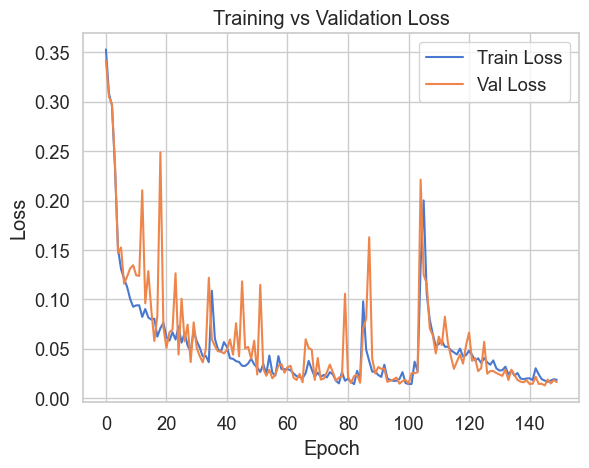

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [31]:
def predict(model, dataset, true_label):
    model.eval()
    errors = []

    with torch.no_grad():
        for seq in dataset:
            seq = seq.to(device)
            reconstructed = model(seq)
            loss = loss_fn(reconstructed, seq)
            errors.append(loss.item())

    return pd.DataFrame({
        "reconstruction_error": errors,
        "true_class": [true_label] * len(errors)
    })


In [32]:
# Normal = class 0, Anomaly = class 1
normal_predictions = predict(model, test_dataset, true_label=0)
anomaly_predictions = predict(model, test_anomaly_dataset, true_label=1)


In [33]:
predictions = pd.concat([normal_predictions, anomaly_predictions])


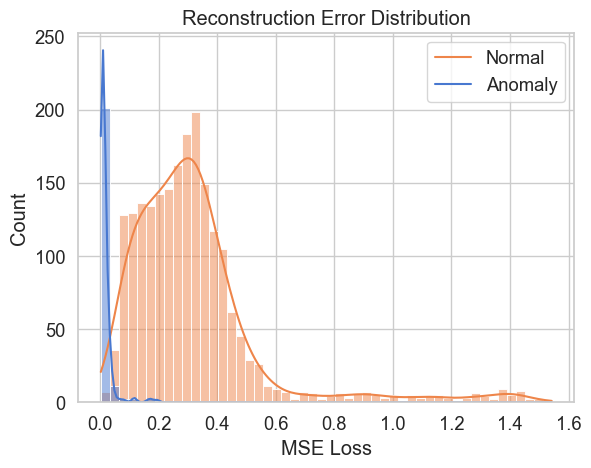

In [34]:
import seaborn as sns

sns.histplot(data=predictions, x="reconstruction_error", hue="true_class", bins=50, kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Loss")
plt.ylabel("Count")
plt.legend(labels=["Normal", "Anomaly"])
plt.show()


In [35]:
threshold = predictions[predictions["true_class"] == 0]["reconstruction_error"].quantile(0.95)


In [36]:
predictions["predicted_class"] = predictions["reconstruction_error"] > threshold
predictions["predicted_class"] = predictions["predicted_class"].astype(int)


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = predictions["true_class"]
y_pred = predictions["predicted_class"]

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       219
           1       0.99      1.00      1.00      2081

    accuracy                           0.99      2300
   macro avg       0.98      0.97      0.98      2300
weighted avg       0.99      0.99      0.99      2300

[[ 208   11]
 [   7 2074]]


In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)


0.9921739130434782